In [26]:
'''This script demonstrates how to build a variational autoencoder with Keras.
 #Reference
 - Auto-Encoding Variational Bayes
   https://arxiv.org/abs/1312.6114
'''
from __future__ import print_function

import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

from keras.layers import Input, Dense, Lambda, Conv2D, Conv2DTranspose, Reshape, BatchNormalization, LeakyReLU
from keras.models import Model
from keras import backend as K
from keras import metrics
from keras.datasets import mnist

batch_size = 100
original_dim = 784
img_rows, img_cols, img_channels = 28, 28, 1
latent_dim = 2
intermediate_dim = 100
epochs = 15
epsilon_std = 1.0

x = Input(shape=(original_dim,))
a = Reshape((img_rows, img_cols, img_channels))(x)
a = Conv2D(32, 3, strides=(2,2), padding='same')(a)
a = BatchNormalization()(a)
a = LeakyReLU()(a)
a = Conv2D(64, 3, strides=(2,2), padding='same')(a)
a = BatchNormalization()(a)
a = LeakyReLU()(a)
a = Conv2D(128, 3, strides=(2,2), padding='same')(a)
a = BatchNormalization()(a)
a = LeakyReLU()(a)
a = Flatten()(a)
h = Dense(intermediate_dim, activation='relu')(a)
z_mean = Dense(latent_dim)(h)
z_log_var = Dense(latent_dim)(h)

def sampling(args):
    z_mean, z_log_var = args
    epsilon = K.random_normal(shape=(K.shape(z_mean)[0], latent_dim), mean=0.,
                              stddev=epsilon_std)
    return z_mean + K.exp(z_log_var / 2) * epsilon

# note that "output_shape" isn't necessary with the TensorFlow backend
z = Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_var])

# we instantiate these layers separately so as to reuse them later
decoder_h = Dense(intermediate_dim, activation='relu')
decoder_fc = Dense(2048, activation='relu')
decoder_reshape = Reshape((128, 4, 4))
decoder_conv1 = Conv2DTranspose(64, 3)
decoder_bn1 = BatchNormalization()
decoder_activ1 = LeakyReLU()
decoder_conv2 = Conv2DTranspose(32, 3)
decoder_bn2 = BatchNormalization()
decoder_activ2 = LeakyReLU()
decoder_conv3 = Conv2DTranspose(1, 3)
decoder_flatten = Flatten()
decoder_mean = Dense(original_dim, activation='sigmoid')

h_decoded = decoder_h(z)
a = decoder_fc(h_decoded)
a = decoder_reshape(a)
a = decoder_conv1(a)
a = decoder_bn1(a)
a = decoder_activ1(a)
a = decoder_conv2(a)
a = decoder_bn2(a)
a = decoder_activ2(a)
a = decoder_conv3(a)
a = decoder_flatten(a)
x_decoded_mean = decoder_mean(a)

# instantiate VAE model
vae = Model(x, x_decoded_mean)

# Compute VAE loss
xent_loss = original_dim * metrics.binary_crossentropy(x, x_decoded_mean)
kl_loss = - 0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
vae_loss = K.mean(xent_loss + kl_loss)

vae.add_loss(vae_loss)
vae.compile(optimizer='rmsprop')
vae.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            (None, 784)          0                                            
__________________________________________________________________________________________________
reshape_5 (Reshape)             (None, 28, 28, 1)    0           input_4[0][0]                    
__________________________________________________________________________________________________
conv2d_10 (Conv2D)              (None, 14, 14, 32)   320         reshape_5[0][0]                  
__________________________________________________________________________________________________
batch_normalization_9 (BatchNor (None, 14, 14, 32)   128         conv2d_10[0][0]                  
__________________________________________________________________________________________________
leaky_re_l

/home/tadenoud/.virtualenvs/ml/local/lib/python3.5/site-packages/ipykernel_launcher.py:87: UserWarning: Output "dense_17" missing from loss dictionary. We assume this was done on purpose, and we will not be expecting any data to be passed to "dense_17" during training.


In [27]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 13245231842166504109
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 3391553536
locality {
  bus_id: 1
  links {
  }
}
incarnation: 12897753564655987998
physical_device_desc: "device: 0, name: GeForce GTX 1050, pci bus id: 0000:01:00.0, compute capability: 6.1"
]


In [28]:
# train the VAE on MNIST digits
(x_train, y_train), (x_test, y_test) = mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))

vae.fit(x_train,
        shuffle=True,
        epochs=epochs,
        batch_size=batch_size,
        validation_data=(x_test, None))

vae.save('vae.h5')

Train on 60000 samples, validate on 10000 samples
Epoch 1/15
60000/60000 [==============================] - 68s 1ms/step - loss: 172.4387 - val_loss: 163.1108
Epoch 2/15
60000/60000 [==============================] - 60s 1ms/step - loss: 157.6498 - val_loss: 155.9823
Epoch 3/15
60000/60000 [==============================] - 55s 921us/step - loss: 154.1289 - val_loss: 154.5978
Epoch 4/15
60000/60000 [==============================] - 55s 917us/step - loss: 152.2770 - val_loss: 151.0737
Epoch 5/15
60000/60000 [==============================] - 55s 921us/step - loss: 150.9090 - val_loss: 149.8169
Epoch 6/15
60000/60000 [==============================] - 55s 916us/step - loss: 149.9730 - val_loss: 149.2323
Epoch 7/15
60000/60000 [==============================] - 57s 947us/step - loss: 149.2711 - val_loss: 149.2805
Epoch 8/15
60000/60000 [==============================] - 54s 905us/step - loss: 148.6436 - val_loss: 150.8544
Epoch 9/15
60000/60000 [==============================] - 57s 949u

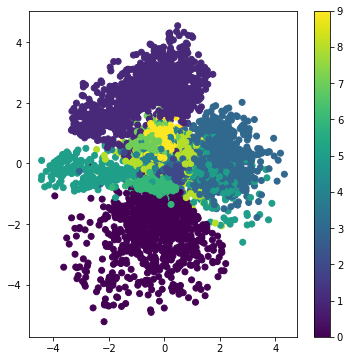

In [29]:
# build a model to project inputs on the latent space
encoder = Model(x, z_mean)

# display a 2D plot of the digit classes in the latent space
x_test_encoded = encoder.predict(x_test, batch_size=batch_size)
plt.figure(figsize=(6, 6))
plt.scatter(x_test_encoded[:, 0], x_test_encoded[:, 1], c=y_test)
plt.colorbar()
plt.show()

encoder.save('encoder.h5')

In [30]:
import json
with open('../src/encoded.json', 'w') as outfile:
    data = [[float(x), float(y), int(l)] for [x, y], l in zip(x_test_encoded, y_test)]
    json.dump(data, outfile)


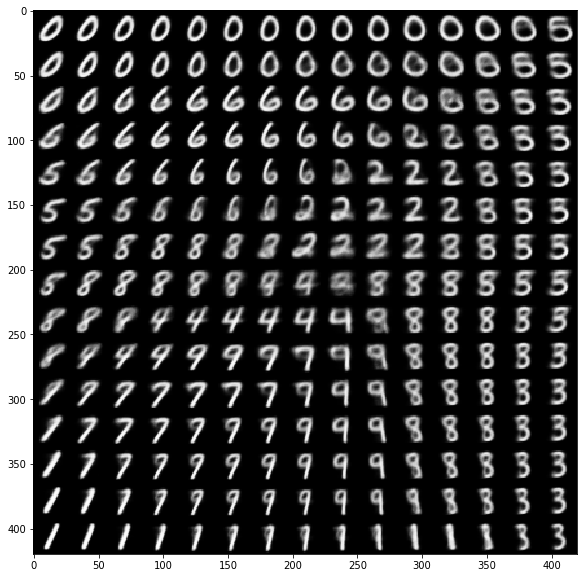

In [32]:
# build a digit generator that can sample from the learned distribution
decoder_input = Input(shape=(latent_dim,))
_h_decoded = decoder_h(decoder_input)
_a = decoder_fc(_h_decoded)
_a = decoder_reshape(_a)
_a = decoder_conv1(_a)
_a = decoder_bn1(_a)
_a = decoder_activ1(_a)
_a = decoder_conv2(_a)
_a = decoder_bn2(_a)
_a = decoder_activ2(_a)
_a = decoder_conv3(_a)
_a = decoder_flatten(_a)
_x_decoded_mean = decoder_mean(_a)
generator = Model(decoder_input, _x_decoded_mean)

# display a 2D manifold of the digits
n = 15  # figure with 15x15 digits
digit_size = 28
figure = np.zeros((digit_size * n, digit_size * n))
# linearly spaced coordinates on the unit square were transformed through the inverse CDF (ppf) of the Gaussian
# to produce values of the latent variables z, since the prior of the latent space is Gaussian
grid_x = norm.ppf(np.linspace(0.05, 0.95, n))
grid_y = norm.ppf(np.linspace(0.05, 0.95, n))

for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        z_sample = np.array([[xi, yi]])
        x_decoded = generator.predict(z_sample)
        digit = x_decoded[0].reshape(digit_size, digit_size)
        figure[i * digit_size: (i + 1) * digit_size,
               j * digit_size: (j + 1) * digit_size] = digit

plt.figure(figsize=(10, 10))
plt.imshow(figure, cmap='Greys_r')
plt.show()

generator.save('generator.h5')

In [33]:
import tensorflowjs as tfjs

tfjs.converters.save_keras_model(generator, '../public/models/generatorjs')